In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import os
import re 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import math
import matplotlib.patches as patches

from tensorflow.keras import layers

### 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load data from Google Drive
'''base_path = '/content/drive/MyDrive/slides/'
file_names = os.listdir(base_path)

names = list(filter(lambda v: re.match('tumor_\d+.tif', v), file_names))

name_dict = {}
mask_names = []
slide_names = []
for name in names:
  mask_name = base_path + 'tumor_' + re.findall(r'\d+', name)[0]+'_mask.tif'
  if os.path.exists(mask_name) and os.path.exists(base_path + name):
    name_dict[base_path + name] = mask_name
    mask_names.append(mask_name)
    slide_names.append(base_path + name)
'''

In [ ]:
# Load data from cloud
from google.colab import drive
drive.mount('/content/drive')

f = open("/content/drive/MyDrive/wsi-urls.txt", "r")
file_names = [line.strip() for line in f.readlines()]
base_path = 'https://storage.googleapis.com/applied-dl/tumor-slides/'

names = list(filter(lambda v: re.match('.*?(tumor_\d+.tif)', v), file_names))
part_names = [name.split('/')[-1] for name in names]

name_dict = {}

slide_paths = []
slide_urls = []
tumor_mask_paths = []
mask_urls = []

for name in part_names:
  mask_name = 'tumor_' + re.findall(r'\d+', name)[0]+'_mask.tif'
  if (base_path+ mask_name) in file_names and (base_path + name) in file_names:
    name_dict[name] = mask_name
    mask_urls.append(base_path+ mask_name)
    slide_urls.append(base_path + name)
    slide_paths.append(name)
    tumor_mask_paths.append(mask_name)
for slide_path in slide_paths:

  # Download the whole slide image
  if not os.path.exists(slide_path):
    slide_url = base_path + slide_path
    !curl -O $slide_url
for tumor_mask_path in tumor_mask_paths:
  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    mask_url = base_path + tumor_mask_path
    !curl -O $mask_url

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
slide_train_val, slide_test, mask_train_val, mask_test = train_test_split(slide_paths, tumor_mask_paths, test_size = 4, random_state = 42)
slide_train, slide_val, mask_train, mask_val = train_test_split(slide_train_val, mask_train_val, test_size = 4, random_state = 42)
print('Number of slides for training:', len(slide_train))
print('Number of slides for validation:', len(slide_val))
print('Number of slides for test:', len(slide_test))

Number of slides for training: 12
Number of slides for validation: 4
Number of slides for test: 4


In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def find_nontissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray > intensity)
    return list(zip(indices[0], indices[1]))
def remove_nontissue(im, mask, color = (0,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

### 2. Visualization

#### 2.1 Visualization on patches

In [ ]:
base_path = 'https://storage.googleapis.com/applied-dl/tumor-slides/'
slide_url = base_path + slide_train[1]
!curl -O $slide_url
mask_url = base_path + mask_train[1]
!curl -O $mask_url

In [ ]:
level_downsample = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128, 8:256}
patch_size = 299
center_size = 128
diff = (patch_size - center_size)//2

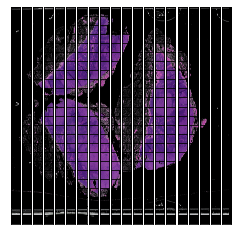

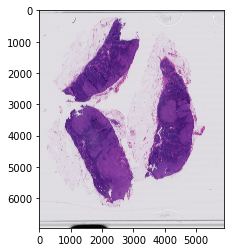

In [ ]:
# Visualization on pathes of slides
level = 4
slide = open_slide(slide_train[1])
fig, axes = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])), gridspec_kw = {'wspace':0, 'hspace':0})
fig.subplots_adjust(right =0.64,wspace=0,hspace=0)
all_patches = []
all_slide_patches = []
row, col = 0, 0
for i in range(0, slide.level_dimensions[0][1], patch_size*level_downsample[level]):
    for j in range(0, slide.level_dimensions[0][0], patch_size*level_downsample[level]):
      slide_patch = read_slide(slide, j, i , level, patch_size, patch_size)
      tissue_pixels = find_nontissue_pixels(slide_patch)
      tissue_patch = remove_nontissue(slide_patch, tissue_pixels)
      all_patches.append(tissue_patch)
      all_slide_patches.append(slide_patch)
      axes[row][col].imshow(tissue_patch)
      axes[row][col].set_xticks([])
      axes[row][col].set_yticks([])
      col+=1
    col = 0
    row+=1
plt.show()
plt.imshow(read_slide(slide, 0, 0 , level, slide.level_dimensions[level][0], slide.level_dimensions[level][1]))
plt.show()

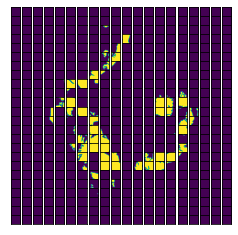

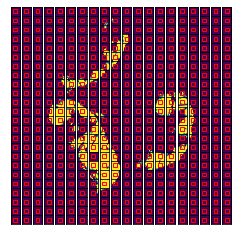

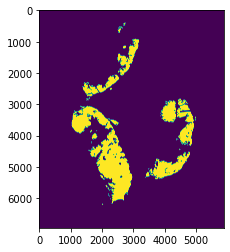

In [ ]:
# Visualization on patches of mask
tumor_mask = open_slide(mask_train[1])
fig, axes = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])))
fig1, axes1 = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])))
all_center = []
row, col = 0, 0
for i in range(0, slide.level_dimensions[0][1], patch_size*level_downsample[level]):
    for j in range(0, slide.level_dimensions[0][0], patch_size*level_downsample[level]):
      center = read_slide(tumor_mask, j + diff*level_downsample[level], i+diff*level_downsample[level], level, center_size, center_size)[:,:,0]
      all_center.append(center)
      axes[row][col].imshow(center)
      axes[row][col].set_xticks([])
      axes[row][col].set_yticks([])

      axes1[row][col].imshow(read_slide(tumor_mask, j, i , level, patch_size, patch_size)[:,:,0])
      axes1[row][col].set_xticks([])
      axes1[row][col].set_yticks([])
      rect = patches.Rectangle((diff,diff),center_size,center_size,linewidth=1,edgecolor='r',facecolor='none')
      axes1[row][col].add_patch(rect)
      
      col+=1
    col = 0
    row+=1
fig.subplots_adjust(right =0.64,wspace=0,hspace=0)
fig1.subplots_adjust(right =0.64,wspace=0,hspace=0)
plt.show()

plt.imshow(read_slide(tumor_mask, 0, 0 , level, slide.level_dimensions[level][0], slide.level_dimensions[level][1])[:,:,0])
# plt.xticks([])
# plt.yticks([])
plt.show()

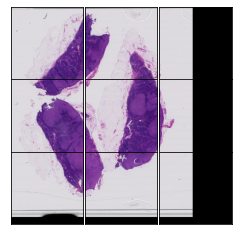

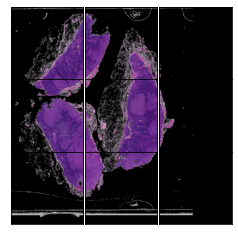

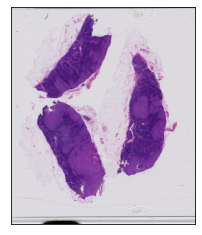

In [ ]:
# Visualization on pathes of slides
level = 7
slide = open_slide(slide_train[1])
fig, axes = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])), gridspec_kw = {'wspace':0, 'hspace':0})
fig.subplots_adjust(right =0.64,wspace=0,hspace=0)
fig1, axes1 = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])), gridspec_kw = {'wspace':0, 'hspace':0})
fig1.subplots_adjust(right =0.64,wspace=0,hspace=0)
row, col = 0, 0
for i in range(0, slide.level_dimensions[0][1], patch_size*level_downsample[level]):
    for j in range(0, slide.level_dimensions[0][0], patch_size*level_downsample[level]):
      slide_patch = read_slide(slide, j, i , level, patch_size, patch_size)
      tissue_pixels = find_nontissue_pixels(slide_patch)
      tissue_patch = remove_nontissue(slide_patch, tissue_pixels)

      axes[row][col].imshow(slide_patch)
      axes[row][col].set_xticks([])
      axes[row][col].set_yticks([])

      axes1[row][col].imshow(tissue_patch)
      axes1[row][col].set_xticks([])
      axes1[row][col].set_yticks([])
      col+=1
    col = 0
    row+=1
plt.show()
plt.imshow(read_slide(slide, 0, 0 , level, slide.level_dimensions[level][0], slide.level_dimensions[level][1]))
plt.xticks([])
plt.yticks([])
plt.show()

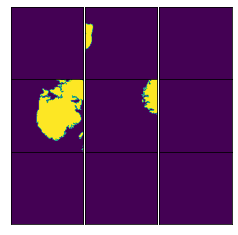

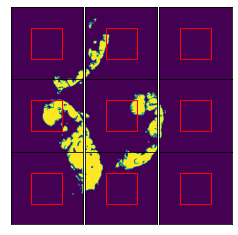

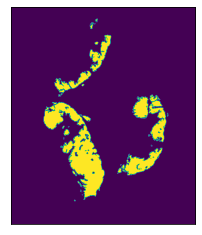

In [ ]:
# Visualization on patches of mask
tumor_mask = open_slide(mask_train[1])
fig, axes = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])))
fig1, axes1 = plt.subplots(math.ceil(slide.level_dimensions[0][1]/(patch_size*level_downsample[level])), math.ceil(slide.level_dimensions[0][0]/(patch_size*level_downsample[level])))

row, col = 0, 0
for i in range(0, slide.level_dimensions[0][1], patch_size*level_downsample[level]):
    for j in range(0, slide.level_dimensions[0][0], patch_size*level_downsample[level]):
      center = read_slide(tumor_mask, j + diff*level_downsample[level], i+diff*level_downsample[level], level, center_size, center_size)[:,:,0]
      axes[row][col].imshow(center)
      axes[row][col].set_xticks([])
      axes[row][col].set_yticks([])

      axes1[row][col].imshow(read_slide(tumor_mask, j, i , level, patch_size, patch_size)[:,:,0])
      axes1[row][col].set_xticks([])
      axes1[row][col].set_yticks([])
      rect = patches.Rectangle((diff,diff),center_size,center_size,linewidth=1,edgecolor='r',facecolor='none')
      axes1[row][col].add_patch(rect)
      
      col+=1
    col = 0
    row+=1
fig.subplots_adjust(right =0.64,wspace=0,hspace=0)
fig1.subplots_adjust(right =0.64,wspace=0,hspace=0)
plt.show()

plt.imshow(read_slide(tumor_mask, 0, 0 , level, slide.level_dimensions[level][0], slide.level_dimensions[level][1])[:,:,0])
plt.xticks([])
plt.yticks([])
plt.show()

#### 2.2 Visulization on different levels of the same center

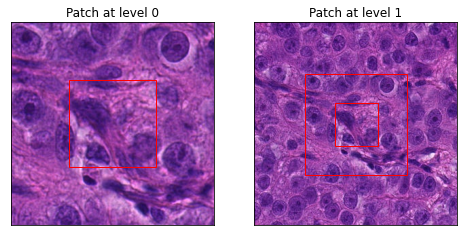

In [ ]:
# With the same center
level_downsample = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128, 8:256}
level = 7
patch_size = 299
center_size = 128
diff = (patch_size - center_size)//2
slide = open_slide(slide_train[1])
fig, axes = plt.subplots(1,2, figsize = (8,8))
axes[0].imshow(read_slide(slide, 38400, 76800 , 0, 299, 299, as_float=False))
rect = patches.Rectangle((diff,diff),center_size,center_size,linewidth=1,edgecolor='r',facecolor='none')
axes[0].add_patch(rect)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Patch at level 0')
axes[1].imshow(read_slide(slide, 38400 + 150 -150*int(slide.level_downsamples[1]), 76800 + 150 -150*int(slide.level_downsamples[1]), 1, 299, 299, as_float=False))
rect1 = patches.Rectangle((150//2, 150//2), 299//2, 299//2,linewidth=1,edgecolor='r',facecolor='none')
axes[1].add_patch(rect1)
rect2 = patches.Rectangle((150//2+43, 150//2+43), 128//2, 128//2,linewidth=1,edgecolor='r',facecolor='none')
axes[1].add_patch(rect2)

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Patch at level 1')
plt.show()

### 3. Splitting to patches

#### 3.1 Data Preparing

In [ ]:
level_downsample = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128, 8:256}
level = 2
patch_size = 299
center_size = 128
diff = (patch_size - center_size)//2

def get_patches(slide_paths, mask_paths, for_training = True, for_eval = False):
  X, y = [], []
  for slide_path, tumor_mask_path in zip(slide_paths, mask_paths):
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)

    X_one = []
    y_one = []
    for i in range(0, slide.level_dimensions[0][1], patch_size*level_downsample[level]):
      for j in range(0, slide.level_dimensions[0][0], patch_size*level_downsample[level]):
        slide_patch = read_slide(slide, j, i , level, patch_size, patch_size)
        tissue_pixels = find_nontissue_pixels(slide_patch)
        tissue_patch = remove_nontissue(slide_patch, tissue_pixels)
        if for_eval == True:
          X_one.append(slide_patch)
          center = read_slide(tumor_mask, j + diff*level_downsample[level], i+diff*level_downsample[level], level, center_size, center_size)[:,:,0]
          if np.sum(center)>0:
            y_one.append(1.0)
          else:
            y_one.append(0.0)
        elif for_training == True:
          if np.sum(tissue_patch)!=0:
            X_one.append(tissue_patch)
            center = read_slide(tumor_mask, j + diff*level_downsample[level], i+diff*level_downsample[level], level, center_size, center_size)[:,:,0]
            if np.sum(center)>0:
              y_one.append(1.0)
            else:
              y_one.append(0.0)
        else:
          X_one.append(tissue_patch)
          center = read_slide(tumor_mask, j + diff*level_downsample[level], i+diff*level_downsample[level], level, center_size, center_size)[:,:,0]
          if np.sum(center)>0:
            y_one.append(1.0)
          else:
            y_one.append(0.0)
    print("Done: ", slide_path)
    X.extend(np.array(X_one))
    y.extend(np.array(y_one))

  return np.array(X), np.array(y)
  

In [ ]:
%%time
X_train, y_train = get_patches(slide_train, mask_train)

Done:  tumor_064.tif
Done:  tumor_078.tif
Done:  tumor_059.tif
Done:  tumor_110.tif
Done:  tumor_075.tif
Done:  tumor_031.tif
Done:  tumor_101.tif
Done:  tumor_012.tif
Done:  tumor_019.tif


In [ ]:
X_val_pre, y_val_pre = get_patches(slide_val, mask_val, for_training = True)

In [ ]:
X_val_pre.shape, y_val_pre.shape

In [ ]:
'''!mkdir -p '/content/drive/MyDrive/Data/level2/'
with open('/content/drive/MyDrive/Data/level2/y_train.npy', 'wb') as f:
  np.save(f, y_train)
with open('/content/drive/MyDrive/Data/level2/X_train.npy', 'wb') as f:
  np.save(f, X_train)
with open('/content/drive/MyDrive/Data/level2/y_val.npy', 'wb') as f:
  np.save(f, y_val)
with open('/content/drive/MyDrive/Data/level2/X_val.npy', 'wb') as f:
  np.save(f, X_val)'''

#### 3.2 Loading prepared data

In [ ]:
import os
import numpy as np
TrainingData_path = 'https://storage.googleapis.com/jc5299/TrainingData'
X_val_path = 'https://storage.googleapis.com/jc5299/X_val_pre.npy'
y_val_path = 'https://storage.googleapis.com/jc5299/y_val_pre.npy'
if not os.path.exists('X_val_pre.npy'):
  !curl -O $X_val_path

# Download the tumor mask
if not os.path.exists('y_val_pre.npy'):
  !curl -O $y_val_path
if not os.path.exists('TrainingData'):
  !curl -O $TrainingData_path

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5392M  100 5392M    0     0   149M      0  0:00:36  0:00:36 --:--:--  127M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  164k  100  164k    0     0  8241k      0 --:--:-- --:--:-- --:--:-- 8241k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.8G  100 14.8G    0     0   113M      0  0:02:14  0:02:14 --:--:--  160M


In [ ]:
with np.load('/content/TrainingData') as data:
    X_train = data['x']
    y_train = data['y']


In [ ]:
X_val = np.load('/content/X_val_pre.npy')
y_val = np.load('/content/y_val_pre.npy')

In [ ]:
#X_train = np.load('/content/drive/MyDrive/Data/level2/X_train.npy')
#y_train = np.load('/content/drive/MyDrive/Data/level2/y_train.npy')
#X_val = np.load('/content/drive/MyDrive/Data/level2/X_val.npy')
#y_val = np.load('/content/drive/MyDrive/Data/level2/y_val.npy')
#X_val = np.load('/content/drive/MyDrive/Data/level2/X_val_pre.npy')
#y_val = np.load('/content/drive/MyDrive/Data/level2/y_val_pre.npy')

### 4. Data Augmentation

In [ ]:
flip = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 42)
rotation1 = layers.experimental.preprocessing.RandomRotation(0.1, seed = 42)
rotation2 = layers.experimental.preprocessing.RandomRotation(0.2, seed = 42)
#rotation3 = layers.experimental.preprocessing.RandomRotation(0.3, seed = 42)
rotation4 = layers.experimental.preprocessing.RandomRotation(0.4, seed = 42)
rotation5 = layers.experimental.preprocessing.RandomRotation(0.6, seed = 42)
#rotation6 = layers.experimental.preprocessing.RandomRotation(0.7, seed = 42)
rotation7 = layers.experimental.preprocessing.RandomRotation(0.8, seed = 42)
rotation8 = layers.experimental.preprocessing.RandomRotation(0.9, seed = 42)
contrast = tf.keras.layers.experimental.preprocessing.RandomContrast(0.8, seed = 42)

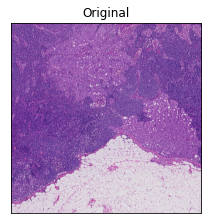

In [ ]:
fig = plt.figure(figsize=(3.5,3.5))
plt.imshow(slide_details)
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.show()

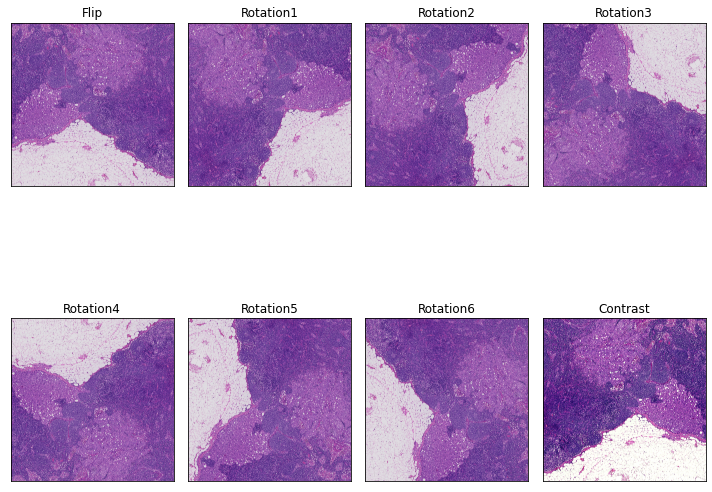

In [ ]:
fig, axes = plt.subplots(2,4, figsize = (10,10))
axes[0][0].imshow(flip(tf.expand_dims(slide_details, axis = 0))[0])
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][0].set_title('Flip')

axes[0][1].imshow(rotation1(tf.expand_dims(slide_details, axis = 0))[0])
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[0][1].set_title('Rotation1')

axes[0][2].imshow(rotation2(tf.expand_dims(slide_details, axis = 0))[0])
axes[0][2].set_xticks([])
axes[0][2].set_yticks([])
axes[0][2].set_title('Rotation2')

axes[0][3].imshow(rotation4(tf.expand_dims(slide_details, axis = 0))[0])
axes[0][3].set_xticks([])
axes[0][3].set_yticks([])
axes[0][3].set_title('Rotation3')

axes[1][0].imshow(rotation5(tf.expand_dims(slide_details, axis = 0))[0])
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])
axes[1][0].set_title('Rotation4')


axes[1][1].imshow(rotation7(tf.expand_dims(slide_details, axis = 0))[0])
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][1].set_title('Rotation5')

axes[1][2].imshow(rotation8(tf.expand_dims(slide_details, axis = 0))[0])
axes[1][2].set_xticks([])
axes[1][2].set_yticks([])
axes[1][2].set_title('Rotation6')

axes[1][3].imshow(contrast(tf.expand_dims(slide_details, axis = 0))[0])
axes[1][3].set_xticks([])
axes[1][3].set_yticks([])
axes[1][3].set_title('Contrast')

fig.subplots_adjust(wspace=0.2,hspace=0.1)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
X_train.shape, y_train.shape

((59373, 299, 299, 3), (59373,))

In [ ]:
X_train_1 = tf.gather(X_train, tf.where(y_train))
y_train_1 = tf.squeeze(tf.gather(y_train, tf.where(y_train)))

In [ ]:
flip = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 42)
rotation1 = layers.experimental.preprocessing.RandomRotation(0.1, seed = 42)
rotation2 = layers.experimental.preprocessing.RandomRotation(0.2, seed = 42)
#rotation3 = layers.experimental.preprocessing.RandomRotation(0.3, seed = 42)
rotation4 = layers.experimental.preprocessing.RandomRotation(0.4, seed = 42)
rotation5 = layers.experimental.preprocessing.RandomRotation(0.6, seed = 42)
#rotation6 = layers.experimental.preprocessing.RandomRotation(0.7, seed = 42)
rotation7 = layers.experimental.preprocessing.RandomRotation(0.8, seed = 42)
rotation8 = layers.experimental.preprocessing.RandomRotation(0.9, seed = 42)
contrast = tf.keras.layers.experimental.preprocessing.RandomContrast(0.8, seed = 42)

aug_flip = tf.map_fn(lambda x: flip(x), X_train_1)
aug_rotation1 = tf.map_fn(lambda x: rotation1(x), X_train_1)
aug_rotation2 = tf.map_fn(lambda x: rotation2(x), X_train_1)
#aug_rotation3 = tf.map_fn(lambda x: rotation3(x), X_train_1)
aug_rotation4 = tf.map_fn(lambda x: rotation4(x), X_train_1)
aug_rotation5 = tf.map_fn(lambda x: rotation5(x), X_train_1)
#aug_rotation6 = tf.map_fn(lambda x: rotation6(x), X_train_1)
aug_rotation7 = tf.map_fn(lambda x: rotation7(x), X_train_1)
aug_rotation8 = tf.map_fn(lambda x: rotation8(x), X_train_1)
aug_contrast = tf.map_fn(lambda x: contrast(x), X_train_1)
#aug_translation = tf.map_fn(lambda x: translation(x), X_train_1)

In [ ]:
aug_X_train = tf.concat([aug_flip,aug_rotation1, aug_rotation2, aug_rotation4, aug_rotation5, aug_rotation7,aug_rotation8,aug_contrast], axis = 0)
aug_y_train = tf.concat([y_train_1, y_train_1, y_train_1, y_train_1, y_train_1,y_train_1,y_train_1, y_train_1],axis = 0)

In [ ]:
np.save('aug_X_train.npy', aug_X_train)
np.save('aug_y_train.npy', aug_y_train)

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_train.npy', y_train)

In [ ]:
with open('X_train_auged.npy', 'wb') as f:
    np.save(f, X_train)
    np.save(f, aug_X_train)
with open('y_train_auged.npy', 'wb') as f:
    np.save(f, y_train)
    np.save(f, aug_y_train)

In [ ]:
def data_augmentation(X_train, y_train):
  X_train_1 = tf.gather(X_train, tf.where(y_train))
  y_train_1 = tf.squeeze(tf.gather(y_train, tf.where(y_train)))

  flip = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 42)
  rotation1 = layers.experimental.preprocessing.RandomRotation(0.1, seed = 42)
  rotation2 = layers.experimental.preprocessing.RandomRotation(0.2, seed = 42)
  #rotation3 = layers.experimental.preprocessing.RandomRotation(0.3, seed = 42)
  rotation4 = layers.experimental.preprocessing.RandomRotation(0.4, seed = 42)
  rotation5 = layers.experimental.preprocessing.RandomRotation(0.6, seed = 42)
  #rotation6 = layers.experimental.preprocessing.RandomRotation(0.7, seed = 42)
  rotation7 = layers.experimental.preprocessing.RandomRotation(0.8, seed = 42)
  rotation8 = layers.experimental.preprocessing.RandomRotation(0.9, seed = 42)
  contrast = tf.keras.layers.experimental.preprocessing.RandomContrast(0.8, seed = 42)

  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: flip(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: rotation1(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: rotation2(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: rotation4(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: rotation5(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: rotation7(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: rotation8(x), X_train_1))], axis = 0)
  X_train = tf.concat([X_train, tf.squeeze(tf.map_fn(lambda x: contrast(x), X_train_1))], axis = 0)
  
  y_train = tf.concat([y_train, 
                     y_train_1, y_train_1, y_train_1, y_train_1, y_train_1,y_train_1,y_train_1, y_train_1],# y_train_1 
                    axis = 0)
  return X_train, y_train

In [ ]:
X_train, y_train = data_augmentation(X_train, y_train)
X_train.shape

### 5. Model

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow import keras
import tensorflow as tf


In [ ]:
import numpy as np
X_train = np.load('X_train_auged.npy' )
y_train = np.load('y_train_auged.npy')

In [ ]:
X_val = np.load('X_val_pre.npy')
y_val = np.load('y_val_pre.npy')

In [ ]:
BATCH_SIZE = 192

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(BATCH_SIZE)

dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_val = dataset_val.shuffle(buffer_size=100)
dataset_val = dataset_val.batch(BATCH_SIZE)

In [ ]:
# Base model: InceptionV3
INPUT_SHAPE = X_train.shape[1:]
Inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
Inception.trainable = True
fine_tune_at = 294
for layer in Inception.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
Inception_model = tf.keras.models.Sequential()
Inception_model.add(Inception)
Inception_model.add(layers.Flatten())
Inception_model.add(layers.Dropout(0.5))
Inception_model.add(layers.Dense(1024, activation = 'relu'))
Inception_model.add(layers.Dropout(0.5))
Inception_model.add(layers.Dense(1024, activation = 'relu'))
Inception_model.add(layers.Dense(1, activation='sigmoid'))
Inception_model.compile(optimizer=tf.keras.optimizers.Adam(0.000001),
              loss = 'binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()
                       ])

In [ ]:

history = Inception_model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs = 5, batch_size= 256) # batch_size=192

# BATCHSIZE = 32
# val_precision: 0.3430 - val_recall: 0.5364 - val_auc: 0.9514 - val_false_positives: 113.0000 - val_true_positives: 59.0000 - val_true_negatives: 20858.0000 - val_false_negatives: 51.0000

# BATCHSIZE = 128
# val_precision: 0.1839 - val_recall: 0.6636 - val_auc: 0.9724 - val_false_positives: 324.0000 - val_true_positives: 73.0000 - val_true_negatives: 20647.0000 - val_false_negatives: 37.0000

# BATCHSIZE = 256
# val_precision: 0.1582 - val_recall: 0.6818 - val_auc: 0.9807 - val_false_positives: 399.0000 - val_true_positives: 75.0000 - val_true_negatives: 20572.0000 - val_false_negatives: 35.0000

In [ ]:
Inception_model.save('/content/drive/MyDrive/saved_model/Inception_level2_one_Batch256')

In [ ]:
Inception_model.save('/content/drive/MyDrive/saved_model/Inception_level2_one')

### 6. Evaluation

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
Inception_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Inception_level2_one_Batch256')

In [ ]:
X_test, y_test = get_patches(slide_test, mask_test, for_training=False)

Done:  tumor_002.tif
Done:  tumor_096.tif
Done:  tumor_091.tif
Done:  tumor_005.tif


In [ ]:
'''with open('/content/drive/MyDrive/Data/level2/y_test.npy', 'wb') as f:
  np.save(f, y_test)
with open('/content/drive/MyDrive/Data/level2/X_test.npy', 'wb') as f:
  np.save(f, X_test)'''

In [ ]:
'''import numpy as np
with open('y_test.npy', 'wb') as f:
  np.save(f, y_test)
with open('X_test.npy', 'wb') as f:
  np.save(f, X_test)'''

In [ ]:
import numpy as np
y_test = np.load('/content/drive/MyDrive/Data/level2/y_test.npy')
X_test = np.load('/content/drive/MyDrive/Data/level2/X_test.npy')

In [ ]:
# X_test, y_test = get_patches(slide_test, mask_test, for_training=False)
BATCH_SIZE = 256
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(buffer_size=100)
dataset_test = dataset_test.batch(BATCH_SIZE)
metric_eval = Inception_model.evaluate(dataset_test)

153/153 [==============================] - 627s 4s/step - loss: 0.0264 - precision: 0.1618 - recall: 0.5185 - auc: 0.9584 - false_positives: 290.0000 - true_positives: 56.0000 - true_negatives: 38718.0000 - false_negatives: 52.0000


In [ ]:
# BATCH 256
TPR = metric_eval[2]
FPR = metric_eval[4]/(metric_eval[4] + len(tf.where(y_test == 0.0)))
# TNR = TN/(TN+ FP)
TNR = metric_evapl[6]/(metric_eval[6] +  metric_eval[4])
FNR = 1 - TPR
AUC = metric_eval[3]
print("True postive rate:", TPR)
print("False postive rate:", FPR)
print("True negative rate:", TNR)
print("False negative rate:", FNR)
print("AUC:", AUC)

True postive rate: 0.5185185074806213
False postive rate: 0.007379510407654334
True negative rate: 0.9925656275635767
False negative rate: 0.48148149251937866
AUC: 0.958441436290741


In [ ]:
# BATCH 128
TPR = metric_eval[2]
FPR = metric_eval[4]/(metric_eval[4] + len(tf.where(y_test == 0.0)))
# TNR = TN/(TN+ FP)
TNR = metric_eval[6]/(metric_eval[6] +  metric_eval[4])
FNR = 1 - TPR
AUC = metric_eval[3]
print("True postive rate:", TPR)
print("False postive rate:", FPR)
print("True negative rate:", TNR)
print("False negative rate:", FNR)
print("AUC:", AUC)

True postive rate: 0.5648148059844971
False postive rate: 0.007177398829218631
True negative rate: 0.9927707136997539
False negative rate: 0.43518519401550293
AUC: 0.978594958782196


In [ ]:
# BATCH 32
TPR = metric_eval[2]
FPR = metric_eval[4]/(metric_eval[4] + len(tf.where(y_test == 0.0)))
# TNR = TN/(TN+ FP)
TNR = metric_eval[6]/(metric_eval[6] +  metric_eval[4])
FNR = 1 - TPR
AUC = metric_eval[3]
print("True postive rate:", TPR)
print("False postive rate:", FPR)
print("True negative rate:", TNR)
print("False negative rate:", FNR)
print("AUC:", AUC)

True postive rate: 0.39814814925193787
False postive rate: 0.002148777243425765
True negative rate: 0.9978465955701394
False negative rate: 0.6018518507480621
AUC: 0.9284892678260803


### 7. Result

In [ ]:
base_path = 'https://storage.googleapis.com/applied-dl/tumor-slides/'
slide_url = base_path + slide_test[2]
!curl -O $slide_url
mask_url = base_path + mask_test[2]
!curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  49.2M      0  0:00:10  0:00:10 --:--:-- 66.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  25.9M      0 --:--:-- --:--:-- --:--:-- 25.9M


In [ ]:
level = 2
side_path, mask_path = slide_test[2], mask_test[2]
slide = open_slide(side_path)
tumor_mask = open_slide(mask_path)
slide_image = read_slide(slide, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])
mask_image = read_slide(tumor_mask, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])[:,:,0]

lower = math.ceil(slide.level_dimensions[level][1]/299)*299 - slide.level_dimensions[level][1]
right = math.ceil(slide.level_dimensions[level][0]/299)*299 - slide.level_dimensions[level][0]
mask_image_padded = tf.keras.layers.ZeroPadding2D(padding=((0, lower), (0, right)))(tf.expand_dims(tf.expand_dims(mask_image, axis = 0), axis = 3))
mask_image_padded = tf.squeeze(mask_image_padded)

slide_image_padded = tf.keras.layers.ZeroPadding2D(padding=((0, lower), (0, right)))(tf.expand_dims(slide_image, axis = 0))
slide_image_padded = tf.squeeze(slide_image_padded)

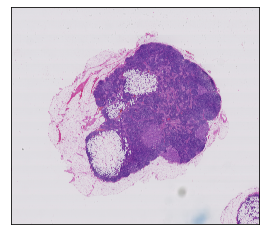

In [ ]:
plt.imshow(slide_image)
plt.xticks([])
plt.yticks([])
plt.show()

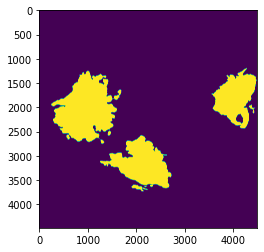

In [ ]:
mask_details = read_slide(tumor_mask, x=31000, y=24000, level=level, width=299*10, height=299*15)[:,:,0]
plt.imshow(mask_details)

#### 7.1 Visulization on details of the slide

In [ ]:
X_eval, y_eval = get_patches([side_path], [mask_path], for_training=False, for_eval = True)
dataset_eval = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))
dataset_eval = dataset_eval.shuffle(buffer_size=100)
dataset_eval = dataset_eval.batch(BATCH_SIZE)
y_eval_pred = Inception_model.predict(X_eval)

In [ ]:
BATCH_SIZE = 256
dataset_eval = dataset_eval.batch(BATCH_SIZE)
y_eval_pred = Inception_model.predict(X_eval)

In [ ]:
y_eval_pred_reshape = []
for j in range(math.ceil(slide.level_dimensions[level][1]/299)):
  patch_row = []
  for i in range(math.ceil(slide.level_dimensions[level][0]/299)):
    patch_row.append(y_eval_pred[j*math.ceil(slide.level_dimensions[level][0]/299) + i][0])
  y_eval_pred_reshape.append(np.array(patch_row))

data = pd.DataFrame(np.array(y_eval_pred_reshape))

In [ ]:
import pandas as pd
import cv2 
from scipy.ndimage import gaussian_filter
import seaborn as sns
data_details = pd.DataFrame(np.array([x[25:35] for x in y_eval_pred_reshape[25:35]]))
sns.heatmap(data_details,  center = 0,square = True, cmap='Reds', xticklabels=False, yticklabels=False, cbar_kws={"shrink": 0.2})

In [ ]:

mask_details = read_slide(tumor_mask, x=299*25*4, y=299*25*4, level=level, width=299*10, height=299*10)[:,:,0]
plt.imshow(mask_details)

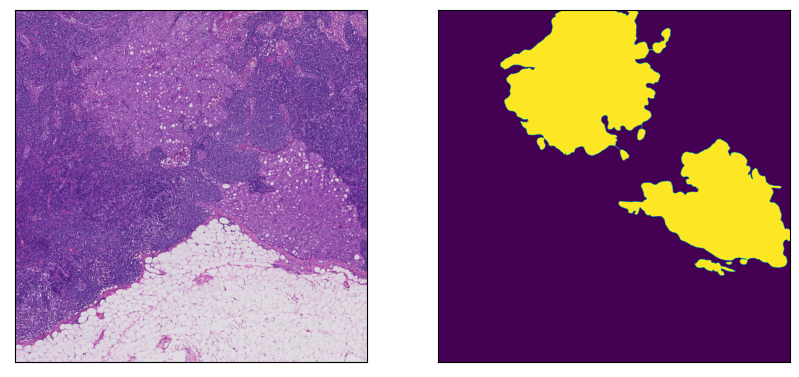

In [ ]:

fig, axes = plt.subplots(1,2, figsize= (10,10), dpi = 100)
axes[0].imshow(slide_details)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(mask_details)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

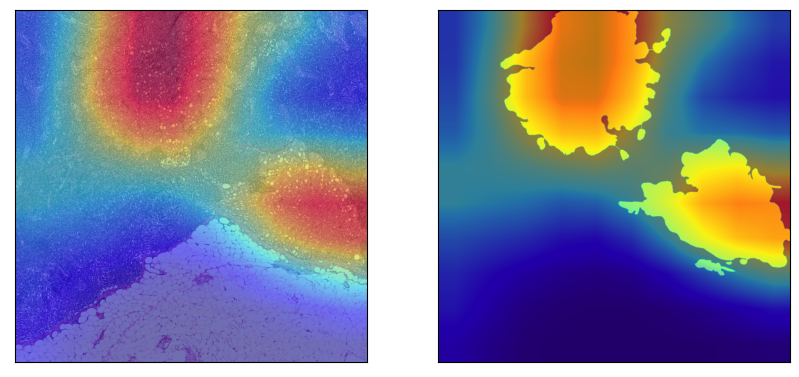

In [ ]:
df_smooth_details = gaussian_filter(data_details, sigma=1)
slide_details = read_slide(slide, x=299*25*4, y=299*25*4, level=level, width=299*10, height=299*10)
resized_image_details = cv2.resize(df_smooth_details, (299*10,299*10))

fig, axes = plt.subplots(1,2, figsize= (10,10), dpi = 100)
axes[0].imshow(slide_details)
axes[0].imshow(resized_image_details, cmap='jet',alpha = 0.5)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(mask_details)
axes[1].imshow(resized_image_details, cmap='jet',alpha = 0.5)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

#### 7.2 Visualization on the whole slide

In [ ]:
import pandas as pd
import cv2 
from scipy.ndimage import gaussian_filter
import seaborn as sns
def visualization(side_path, mask_path):

  #side_path, mask_path = slide_test[2], mask_test[2]
  X_eval, y_eval = get_patches([side_path], [mask_path], for_training=False, for_eval = True)
  dataset_eval = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))
  dataset_eval = dataset_eval.shuffle(buffer_size=100)
  dataset_eval = dataset_eval.batch(BATCH_SIZE)
  y_eval_pred = Inception_model.predict(X_eval)

  slide = open_slide(side_path)
  tumor_mask = open_slide(mask_path)
  slide_image = read_slide(slide, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])[:,:,0]


  lower = math.ceil(slide.level_dimensions[level][1]/299)*299 - slide.level_dimensions[level][1]
  right = math.ceil(slide.level_dimensions[level][0]/299)*299 - slide.level_dimensions[level][0]
  mask_image_padded = tf.keras.layers.ZeroPadding2D(padding=((0, lower), (0, right)))(tf.expand_dims(tf.expand_dims(mask_image, axis = 0), axis = 3))
  mask_image_padded = tf.squeeze(mask_image_padded)

  slide_image_padded = tf.keras.layers.ZeroPadding2D(padding=((0, lower), (0, right)))(tf.expand_dims(slide_image, axis = 0))
  slide_image_padded = tf.squeeze(slide_image_padded)

  y_eval_pred_reshape = []
  for j in range(math.ceil(slide.level_dimensions[level][1]/299)):
    patch_row = []
    for i in range(math.ceil(slide.level_dimensions[level][0]/299)):
      patch_row.append(y_eval_pred[j*math.ceil(slide.level_dimensions[level][0]/299) + i][0])
    y_eval_pred_reshape.append(np.array(patch_row))

  data = pd.DataFrame(np.array(y_eval_pred_reshape)) 
  fig, axes = plt.subplots(1, 2, figsize = (20,20))
  sns.heatmap(data, center = 0,square = True, cmap='Reds', xticklabels=False, yticklabels=False, ax = axes[0], cbar_kws={"shrink": 0.2})
  axes[1].imshow(mask_image)
  axes[1].set_xticks([])
  axes[1].set_yticks([])

  plt.show()

  
  df_smooth = gaussian_filter(data, sigma=2.5)
  resized_image = cv2.resize(df_smooth, (slide_image_padded.shape[1], slide_image_padded.shape[0]))
  fig, axes = plt.subplots(1,2, figsize= (10,10), dpi = 100)
  axes[0].imshow(slide_image_padded)
  axes[0].imshow(resized_image, cmap='jet',alpha = 0.5)
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  axes[1].imshow(mask_image_padded)
  axes[1].imshow(resized_image, cmap='jet',alpha = 0.5)
  axes[1].set_xticks([])
  axes[1].set_yticks([])
  plt.show()


Done:  tumor_091.tif


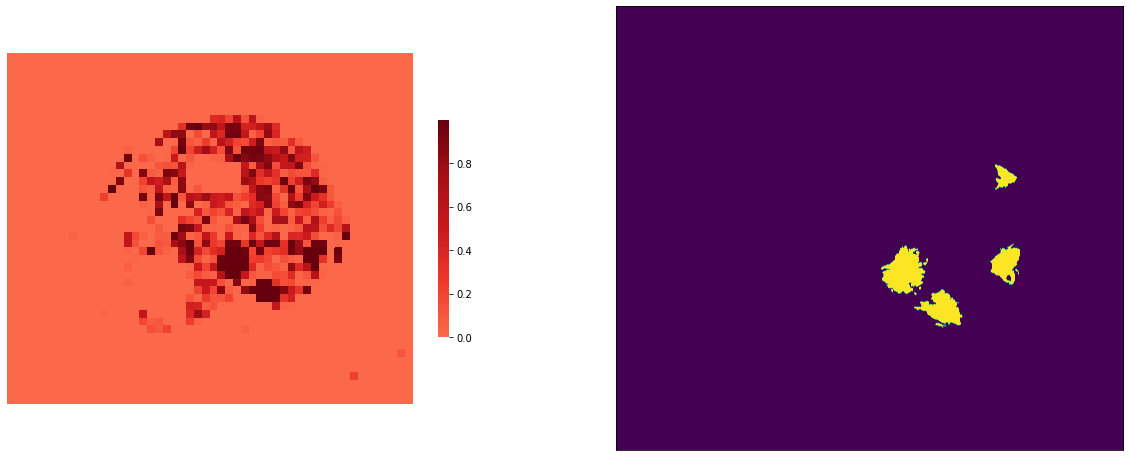

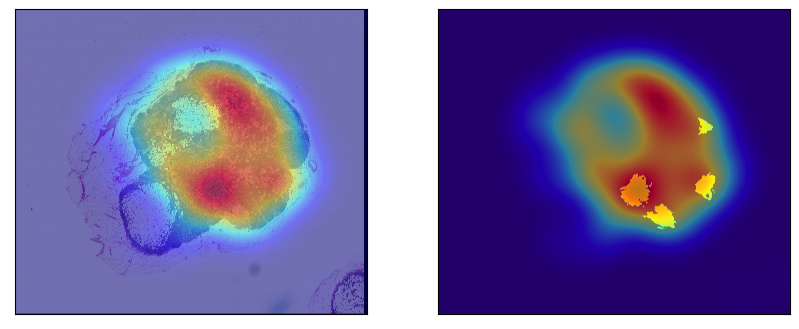

In [ ]:
visualization(slide_test[2], mask_test[2])